In [1]:
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as anim
import numpy as np
%matplotlib notebook

from scipy.constants.constants import C2K
from scipy.constants.constants import K2C
from scipy.constants.constants import F2K
from scipy.constants.constants import K2F
from scipy.constants.constants import C2F
from scipy.constants.constants import F2C

from Libraries import thermodynamics as thermo

In [28]:
n_x = 101
n_y = 101

x = np.linspace(0,6,n_x)
y = np.linspace(0,2,n_y)

X,Y = np.meshgrid(x,y)

d_x = x[1]-x[0]
d_y = y[1]-y[0]

d_t = 0.05
nit=50

air = thermo.FluidArray((n_y+2,n_x+2))
air.Fluid('air')

T_o = 300.
T_b = 350.
T_t = 250.
T_r = T_o

P_o = 1.
rhoref = 1.

g = 9.8

In [3]:
def PresIter(p,u,v,dx,dy,dt,nit):
    pn = p.copy()
    
    co=0
    while co<nit:
        pn = p.copy()
        p[1:-1,1:-1] = (2*pn[1:-1,:-2]*dy**2*dt + 2*pn[1:-1,2:]*dy**2*dt + 2*dx**2*pn[:-2,1:-1]*dt + 2*dx**2*pn[2:,1:-1]*dt - \
                    dx**2*dy*v[2:,1:-1] +dx**2*dy*v[:-2,1:-1] -dx*dy**2*u[1:-1,2:] + dx*dy**2*u[1:-1,:-2])/(4*dt*(dx**2 + dy**2))
        p[:,0], p[:,-1], p[0,:], p[-1,:] = p[:,-2],p[:,1],p[1,:],p[-2,:]
        co+=1
    return p

def Step(steps,ny,nx,dy,dx,dt,To,Tb,Tt,T_ref,Po,rho_ref):
    g = 9.8 #m/s^2
    uo = 0.0
    vo = 0.
    
    T = np.full((ny+2,nx+2),To)
    u = np.full((ny+2,nx+2),uo)
    v = np.full((ny+2,nx+2),vo)
    P = np.full((ny+2,nx+2),Po)
    
    T[:,0], T[:,-1], T[0,:], T[-1,:] = T[:,-2], T[:,1], Tb, Tt

    u[:,0], u[:,-1], u[0,:], u[-1,:] = u[:,-2], u[:,1], 0, 0

    v[:,0], v[:,-1], v[0,:], v[-1,:] = v[:,-2], v[:,1], 0, 0
    
    P[:,0], P[:,-1], P[0,:], P[-1,:] = P[:,-2],P[:,1],P[1,:],P[-2,:]
    
    c = 0
    while c<steps:
        Tn = np.copy(T)
        un = np.copy(u)
        vn = np.copy(v)
        
        air.get_properties(Tn)
        beta = air.beta
        rho = air.rho
        mu = air.mu
        alpha = air.alpha
        
        P = PresIter(P,u,v,dx,dy,dt,nit)
        
        T[1:-1,1:-1] = (Tn[1:-1,1:-1]*dx**2*dy**2 + dt*un[1:-1,1:-1]*dx*dy**2*(-Tn[1:-1,2:] + Tn[1:-1,:-2])/2 + \
                        dt*dx**2*vn[1:-1,1:-1]*dy*(-Tn[2:,1:-1] + Tn[:-2,1:-1])/2 + dt*dx**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1]\
                        + Tn[2:,1:-1] + Tn[:-2,1:-1]) + dt*dy**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1] + Tn[1:-1,2:] + \
                                                                                   Tn[1:-1,:-2]))/(dx**2*dy**2)
        
        u[1:-1,1:-1] = (un[1:-1,1:-1]*dt*dx*dy**2*rho[1:-1,1:-1]*(-un[1:-1,2:] + un[1:-1,:-2])/2 + \
                        un[1:-1,1:-1]*dx**2*dy**2*rho[1:-1,1:-1] + dt*dx**2*vn[1:-1,1:-1]*dy*rho[1:-1,1:-1]*(-un[2:,1:-1] + \
                        un[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[2:,1:-1] + un[:-2,1:-1]) + \
                        dt*dx*dy**2*(-P[1:-1,2:] + P[1:-1,:-2])/2 + dt*dy**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[1:-1,2:] + \
                        un[1:-1,:-2]))/(dx**2*dy**2*rho[1:-1,1:-1])
        
        v[1:-1,1:-1] = (vn[1:-1,1:-1]*dt*dx**2*dy*rho[1:-1,1:-1]*(-vn[2:,1:-1] + vn[:-2,1:-1])/2 + \
                        vn[1:-1,1:-1]*dx**2*dy**2*rho[1:-1,1:-1] + dt*un[1:-1,1:-1]*dx*dy**2*rho[1:-1,1:-1]*(-vn[1:-1,2:] + \
                        vn[1:-1,:-2])/2 + dt*dx**2*dy**2*rho_ref*g*beta[1:-1,1:-1]*(-Tn[1:-1,1:-1] + T_ref) + \
                        dt*dx**2*dy*(-P[2:,1:-1] + P[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[2:,1:-1] + \
                        vn[:-2,1:-1]) + dt*dy**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[1:-1,:-2] + \
                                                                vn[1:-1,2:]))/(dx**2*dy**2*rho[1:-1,1:-1])
        
        u[:,0], u[:,-1], u[0,:], u[-1,:] = u[:,-2], u[:,1], 0, 0

        v[:,0], v[:,-1], v[0,:], v[-1,:] = v[:,-2], v[:,1], 0, 0
        
        P[:,0], P[:,-1], P[0,:], P[-1,:] = P[:,-2],P[:,1],P[1,:],P[-2,:]
        
        c+=1
    return u,v,T,P     

<IPython.core.display.Javascript object>


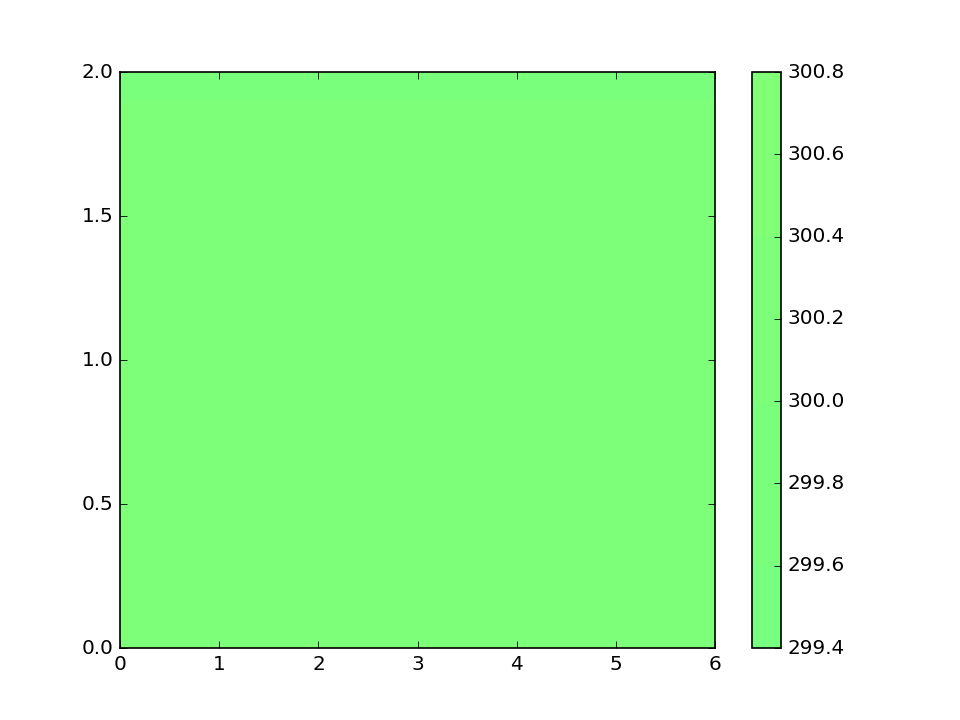

In [18]:
U,V,Temp,Pres = Step(6,n_y,n_x,d_y,d_x,d_t,T_o,T_b,T_t,T_r,P_o,rhoref)

fig = pl.figure(dpi=120)
ax = pl.axes()
cf = pl.contourf(X,Y,Temp[1:-1,1:-1],vmin=T_t,vmax = T_b)
cb = pl.colorbar()
cb.set_clim(T_t,T_b)
cb.update_normal(cf)
#pl.contour(X,Y,Pres[1:-1,1:-1],6,linewidth=1.5)
#pl.streamplot(X,Y,U[1:-1,1:-1],V[1:-1,1:-1],density=0.5,color='k')

1.$$\frac{\partial\vec{v}}{\partial t} = -\vec{v}.\nabla\vec{v} +\nu\nabla^2\vec{v} + \frac{\rho_0}{\rho}g\beta(T-T_\infty)$$
$$\frac{\partial u}{\partial t} = \frac{u*-u^n}{\Delta t}$$
2.$$\nabla^2 P = \frac{1}{\Delta t} div\quad\vec{u}$$
3.$$\frac{u^{n+1}-u*}{\Delta t} = -\nabla P$$

<IPython.core.display.Javascript object>


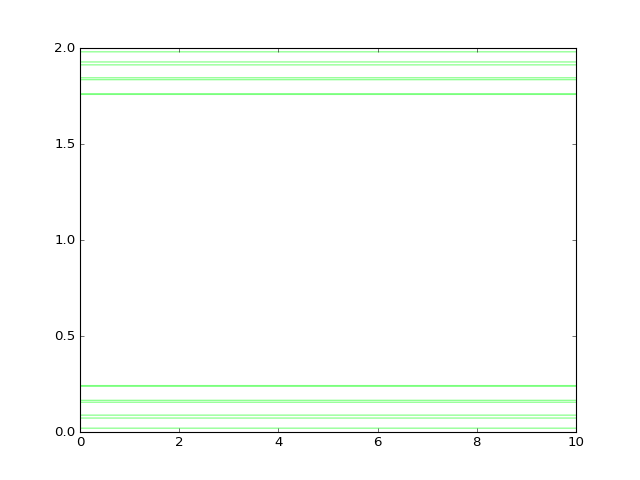

In [82]:
f2 = pl.figure()
#pl.streamplot(X,Y,U[1:-1,1:-1],V[1:-1,1:-1],density=0.9,color='k')
#pl.quiver(X,Y,U[1:-1,1:-1],V[1:-1,1:-1])
pl.contour(X,Y,Pres[1:-1,1:-1],levels = np.linspace(np.amin(Pres[1:-1,1:-1]),np.amax(Pres[1:-1,1:-1]),3),linewidth=1.5)

In [4]:
def OneStep(T,u,v,P,ny,nx,dy,dx,dt,Tb,Tt,T_ref,rho_ref):
    global g
    #uo = 0.0
    #vo = 0.
    
    #T = np.full((ny+2,nx+2),To)
    #u = np.full((ny+2,nx+2),uo)
    #v = np.full((ny+2,nx+2),vo)
    #P = np.full((ny+2,nx+2),Po)
    
    T[:,0], T[:,-1], T[0,:], T[-1,:] = T[:,-2], T[:,1], Tb, Tt

    u[:,0], u[:,-1], u[0,:], u[-1,:] = u[:,-2], u[:,1], 0, 0

    v[:,0], v[:,-1], v[0,:], v[-1,:] = v[:,-2], v[:,1], 0, 0
    
    P[:,0], P[:,-1], P[0,:], P[-1,:] = P[:,-2],P[:,1],P[1,:],P[-2,:]
    
    Tn = np.copy(T)
    un = np.copy(u)
    vn = np.copy(v)

    air.get_properties(Tn)
    beta = air.beta
    rho = air.rho
    mu = air.mu
    alpha = air.alpha

    P = PresIter(P,u,v,dx,dy,dt,nit)

    T[1:-1,1:-1] = (Tn[1:-1,1:-1]*dx**2*dy**2 + dt*un[1:-1,1:-1]*dx*dy**2*(-Tn[1:-1,2:] + Tn[1:-1,:-2])/2 + \
                    dt*dx**2*vn[1:-1,1:-1]*dy*(-Tn[2:,1:-1] + Tn[:-2,1:-1])/2 + dt*dx**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1]\
                    + Tn[2:,1:-1] + Tn[:-2,1:-1]) + dt*dy**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1] + Tn[1:-1,2:] + \
                                                                               Tn[1:-1,:-2]))/(dx**2*dy**2)

    u[1:-1,1:-1] = (un[1:-1,1:-1]*dt*dx*dy**2*rho[1:-1,1:-1]*(-un[1:-1,2:] + un[1:-1,:-2])/2 + \
                    un[1:-1,1:-1]*dx**2*dy**2*rho[1:-1,1:-1] + dt*dx**2*vn[1:-1,1:-1]*dy*rho[1:-1,1:-1]*(-un[2:,1:-1] + \
                    un[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[2:,1:-1] + un[:-2,1:-1]) + \
                    dt*dx*dy**2*(-P[1:-1,2:] + P[1:-1,:-2])/2 + dt*dy**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[1:-1,2:] + \
                    un[1:-1,:-2]))/(dx**2*dy**2*rho[1:-1,1:-1])

    v[1:-1,1:-1] = (vn[1:-1,1:-1]*dt*dx**2*dy*rho[1:-1,1:-1]*(-vn[2:,1:-1] + vn[:-2,1:-1])/2 + \
                    vn[1:-1,1:-1]*dx**2*dy**2*rho[1:-1,1:-1] + dt*un[1:-1,1:-1]*dx*dy**2*rho[1:-1,1:-1]*(-vn[1:-1,2:] + \
                    vn[1:-1,:-2])/2 + dt*dx**2*dy**2*rho_ref*g*beta[1:-1,1:-1]*(-Tn[1:-1,1:-1] + T_ref) + \
                    dt*dx**2*dy*(-P[2:,1:-1] + P[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[2:,1:-1] + \
                    vn[:-2,1:-1]) + dt*dy**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[1:-1,:-2] + \
                                                            vn[1:-1,2:]))/(dx**2*dy**2*rho[1:-1,1:-1])

    u[:,0], u[:,-1], u[0,:], u[-1,:] = u[:,-2], u[:,1], 0, 0

    v[:,0], v[:,-1], v[0,:], v[-1,:] = v[:,-2], v[:,1], 0, 0

    P[:,0], P[:,-1], P[0,:], P[-1,:] = P[:,-2],P[:,1],P[1,:],P[-2,:]
        
    return u,v,T,P   

In [12]:
u_o = 0.0
v_o = 0.

Temp = np.full((n_y+2,n_x+2),T_o)
U = np.full((n_y+2,n_x+2),u_o)
V = np.full((n_y+2,n_x+2),v_o)
Pres = np.full((n_y+2,n_x+2),P_o)

<IPython.core.display.Javascript object>


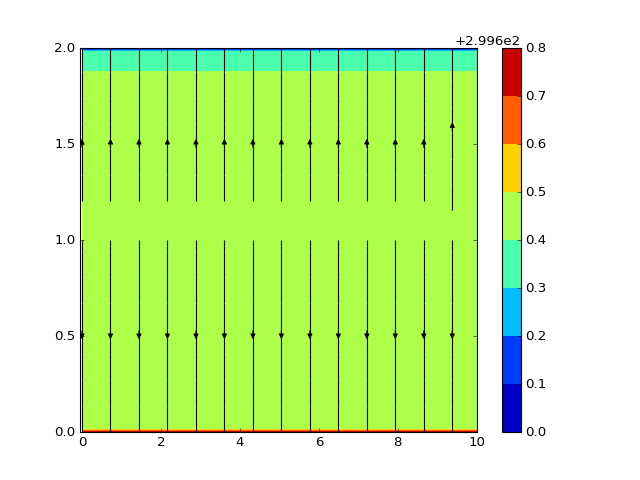

In [18]:
c = 0
while c<10:
    U,V,Temp,Pres = OneStep(Temp,U,V,Pres,n_y,n_x,d_y,d_x,d_t,T_b,T_t,T_r,rhoref)
    c+=1
    
f2 = pl.figure()
ax2 = pl.gca()
cf = ax2.contourf(X,Y,Temp[1:-1,1:-1])
f2.colorbar(cf)
#pl.contour(X,Y,Pres[1:-1,1:-1],6,linewidth=1.5)
ax2.streamplot(X,Y,U[1:-1,1:-1],V[1:-1,1:-1],density=0.5,color='k')

<IPython.core.display.Javascript object>


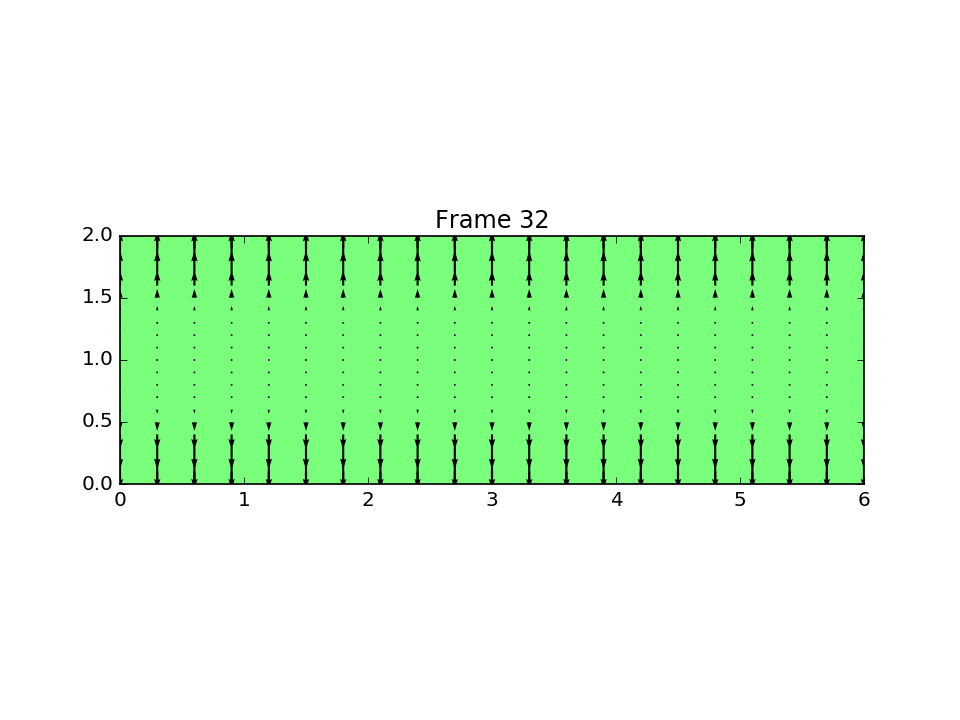

In [20]:
"""
fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i/10.0))  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)
plt.show()"""

fig = pl.figure(dpi=120)
ax = pl.gca()
ax.set_aspect('equal')

Temp = np.full((n_y+2,n_x+2),T_o)
U = np.full((n_y+2,n_x+2),u_o)
#U = np.random.randint(-10,10,size=(n_y+2,n_x+2))*1/100
V = np.full((n_y+2,n_x+2),v_o)
#V = np.random.rand(n_y+2,n_x+2)*0.01
Pres = np.full((n_y+2,n_x+2),P_o)

ax.contourf(X,Y,Temp[1:-1,1:-1],vmin=T_t,vmax = T_b)
#ax.streamplot(X,Y,U[1:-1,1:-1],V[1:-1,1:-1])
ax.quiver(X[::5,::5],Y[::5,::5],U[1:-1:5,1:-1:5],V[1:-1:5,1:-1:5])

def animate(i,T,u,v,P,ny,nx,dy,dx,dt,Tb,Tt,T_ref,rho_ref):
    #OneStep(T,u,v,P,ny,nx,dy,dx,dt,Tb,Tt,T_ref,rho_ref):
    U,V,Temp,Pres = OneStep(T,u,v,P,ny,nx,dy,dx,dt,Tb,Tt,T_ref,rho_ref)
    
    ax.clear()
    ax.contourf(X,Y,Temp[1:-1,1:-1],vmin=T_t,vmax = T_b)
    #ax.streamplot(X,Y,U[1:-1,1:-1],V[1:-1,1:-1],density=.5)
    ax.quiver(X[::5,::5],Y[::5,::5],U[1:-1:5,1:-1:5],V[1:-1:5,1:-1:5])
    title = 'Frame %i'%i
    ax.set_title(title)
    return ax

ani = anim.FuncAnimation(fig,animate,np.arange(1,500),interval=50,blit=False,fargs=(Temp,U,V,Pres,n_y,n_x,d_y,d_x,d_t,\
                                                                                    T_b,T_t,T_r,rhoref))
#ani.save('test.mp4')

In [21]:
def OneStep2(T,u,v,P,ny,nx,dy,dx,dt,Tb,Tt,T_ref,rho_ref):
    global g
    #uo = 0.0
    #vo = 0.
    
    #T = np.full((ny+2,nx+2),To)
    #u = np.full((ny+2,nx+2),uo)
    #v = np.full((ny+2,nx+2),vo)
    #P = np.full((ny+2,nx+2),Po)
    
    T[:,0], T[:,-1], T[0,:], T[-1,:] = T[:,-2], T[:,1], Tb, Tt

    u[:,0], u[:,-1], u[0,:], u[-1,:] = u[:,-2], u[:,1], 0, 0

    v[:,0], v[:,-1], v[0,:], v[-1,:] = v[:,-2], v[:,1], 0, 0
    
    P[:,0], P[:,-1], P[0,:], P[-1,:] = P[:,-2],P[:,1],P[1,:],P[-2,:]
    
    Tn = np.copy(T)
    un = np.copy(u)
    vn = np.copy(v)

    air.get_properties(Tn)
    beta = air.beta
    rho = air.rho
    mu = air.mu
    alpha = air.alpha

    

    T[1:-1,1:-1] = (Tn[1:-1,1:-1]*dx**2*dy**2 + dt*un[1:-1,1:-1]*dx*dy**2*(-Tn[1:-1,2:] + Tn[1:-1,:-2])/2 + \
                    dt*dx**2*vn[1:-1,1:-1]*dy*(-Tn[2:,1:-1] + Tn[:-2,1:-1])/2 + dt*dx**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1]\
                    + Tn[2:,1:-1] + Tn[:-2,1:-1]) + dt*dy**2*alpha[1:-1,1:-1]*(-2*Tn[1:-1,1:-1] + Tn[1:-1,2:] + \
                                                                               Tn[1:-1,:-2]))/(dx**2*dy**2)

    """u[1:-1,1:-1] = (un[1:-1,1:-1]*dt*dx*dy**2*rho[1:-1,1:-1]*(-un[1:-1,2:] + un[1:-1,:-2])/2 + \
                    un[1:-1,1:-1]*dx**2*dy**2*rho[1:-1,1:-1] + dt*dx**2*vn[1:-1,1:-1]*dy*rho[1:-1,1:-1]*(-un[2:,1:-1] + \
                    un[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[2:,1:-1] + un[:-2,1:-1]) + \
                    dt*dx*dy**2*(-P[1:-1,2:] + P[1:-1,:-2])/2 + dt*dy**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[1:-1,2:] + \
                    un[1:-1,:-2]))/(dx**2*dy**2*rho[1:-1,1:-1])

    v[1:-1,1:-1] = (vn[1:-1,1:-1]*dt*dx**2*dy*rho[1:-1,1:-1]*(-vn[2:,1:-1] + vn[:-2,1:-1])/2 + \
                    vn[1:-1,1:-1]*dx**2*dy**2*rho[1:-1,1:-1] + dt*un[1:-1,1:-1]*dx*dy**2*rho[1:-1,1:-1]*(-vn[1:-1,2:] + \
                    vn[1:-1,:-2])/2 + dt*dx**2*dy**2*rho_ref*g*beta[1:-1,1:-1]*(-Tn[1:-1,1:-1] + T_ref) + \
                    dt*dx**2*dy*(-P[2:,1:-1] + P[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[2:,1:-1] + \
                    vn[:-2,1:-1]) + dt*dy**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[1:-1,:-2] + \
                                                            vn[1:-1,2:]))/(dx**2*dy**2*rho[1:-1,1:-1])"""
    
    us[1:-1,1:-1] = (un[1:-1,1:-1]*dt*dx*dy**2*rho[1:-1,1:-1]*(-un[1:-1,2:] + un[1:-1,:-2])/2 + \
                     un[1:-1,1:-1]*dx**2*dy**2*rho[1:-1,1:-1] + dt*dx**2*vn[1:-1,1:-1]*dy*rho[1:-1,1:-1]*(-un[2:,1:-1] + \
                     un[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[2:,1:-1] + un[:-2,1:-1]) + \
                     dt*dy**2*mu[1:-1,1:-1]*(-2*un[1:-1,1:-1] + un[1:-1,2:] + un[1:-1,:-2]))/(dx**2*dy**2*rho[1:-1,1:-1])
    us[:,0], us[:,-1], us[0,:], us[-1,:] = us[:,-2], us[:,1], 0, 0
    v[1:-1,1:-1] = (vn[1:-1,1:-1]*dt*dx**2*dy*rho[1:-1,1:-1]*(-vn[2:,1:-1] + vn[:-2,1:-1])/2 + \
                    vn[1:-1,1:-1]*dx**2*dy**2*rho[1:-1,1:-1] + dt*un[1:-1,1:-1]*dx*dy**2*rho[1:-1,1:-1]*(-vn[1:-1,2:] + \
                    vn[1:-1,:-2])/2 + dt*dx**2*dy**2*rho_ref*g*beta[1:-1,1:-1]*(-Tn[1:-1,1:-1] + T_ref) + \
                    dt*dx**2*dy*(-P[2:,1:-1] + P[:-2,1:-1])/2 + dt*dx**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[2:,1:-1] + \
                    vn[:-2,1:-1]) + dt*dy**2*mu[1:-1,1:-1]*(-2*vn[1:-1,1:-1] + vn[1:-1,2:] + \
                                                            vn[1:-1,:-2]))/(dx**2*dy**2*rho[1:-1,1:-1])
    vs[:,0], vs[:,-1], vs[0,:], vs[-1,:] = vs[:,-2], vs[:,1], 0, 0
    
    P = PresIter(P,us,vs,dx,dy,dt,nit)
    
    u[1:-1,1:-1] = (2*us[1:-1,1:-1]*dx*dy + dt*dx*(-P[2:,1:-1] + P[:-2,1:-1]) + dt*dy*(-P[1:-1,2:] + P[1:-1,:-2]))/(2*dx*dy)
    v[1:-1,1:-1] = (2*vs[1:-1,1:-1]*dx*dy + dt*dx*(-P[2:,1:-1] + P[:-2,1:-1]) + dt*dy*(-P[1:-1,2:] + P[1:-1,:-2]))/(2*dx*dy)
    
    u[:,0], u[:,-1], u[0,:], u[-1,:] = u[:,-2], u[:,1], 0, 0

    v[:,0], v[:,-1], v[0,:], v[-1,:] = v[:,-2], v[:,1], 0, 0

    P[:,0], P[:,-1], P[0,:], P[-1,:] = P[:,-2],P[:,1],P[1,:],P[-2,:]
        
    return u,v,T,P   

<IPython.core.display.Javascript object>


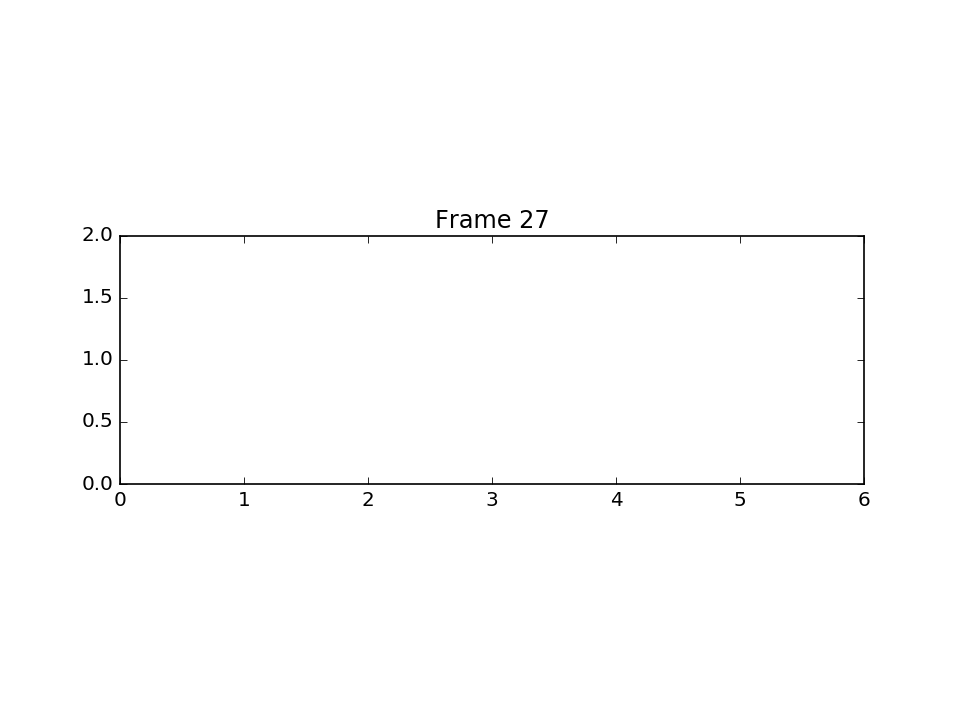

In [29]:
u_o = 0.01
v_o = 0.

fig = pl.figure(dpi=120)
ax = pl.gca()
ax.set_aspect('equal')

Temp = np.full((n_y+2,n_x+2),T_o)
U = np.full((n_y+2,n_x+2),u_o)
V = np.full((n_y+2,n_x+2),v_o)
#V = np.random.rand(n_y+2,n_x+2)*0.01
Pres = np.full((n_y+2,n_x+2),P_o)

ax.contourf(X,Y,Temp[1:-1,1:-1],vmin=T_t,vmax = T_b)
#ax.streamplot(X,Y,U[1:-1,1:-1],V[1:-1,1:-1])
ax.quiver(X[::5,::5],Y[::5,::5],U[1:-1:5,1:-1:5],V[1:-1:5,1:-1:5])

def animate(i,T,u,v,P,ny,nx,dy,dx,dt,Tb,Tt,T_ref,rho_ref):
    #OneStep(T,u,v,P,ny,nx,dy,dx,dt,Tb,Tt,T_ref,rho_ref):
    U,V,Temp,Pres = OneStep(T,u,v,P,ny,nx,dy,dx,dt,Tb,Tt,T_ref,rho_ref)
    
    ax.clear()
    ax.contourf(X,Y,Temp[1:-1,1:-1],vmin=T_t,vmax = T_b)
    #ax.streamplot(X,Y,U[1:-1,1:-1],V[1:-1,1:-1],density=.5)
    ax.quiver(X[::5,::5],Y[::5,::5],U[1:-1:5,1:-1:5],V[1:-1:5,1:-1:5])
    title = 'Frame %i'%i
    ax.set_title(title)
    return ax

ani = anim.FuncAnimation(fig,animate,np.arange(1,290),interval=50,blit=False,fargs=(Temp,U,V,Pres,n_y,n_x,d_y,d_x,d_t,\
                                                                                    T_b,T_t,T_r,rhoref))
#ani.save('test.mp4')